Goal

- list PSMs per assay
- list peptides identified per assay
- Protein amounts: see pooled_proteome_NSAF_1.csv

Investigate relation of PSMs, peptides identified and # protein identifications stratified by project. This will shed insights in the quality of the data done by research groups

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
meta = pd.read_csv("../Metadata/unified_metadata.csv")
meta["Type"] = meta.pool_id.apply(lambda x: "Whole-lysate" if x==0 else "Fraction")

meta["percentage_sign"] = meta.apply(lambda x: x["sign_PSM"]/ x["all_PSM"], axis=1)
meta["PSM_to_pep"] = meta.apply(lambda x: x["peptides"] / x["sign_PSM"], axis = 1)


nsaf = pd.read_hdf("../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

In [17]:
meta.columns

Index(['assay_id', 'project_id', 'filename', 'cell_id', 'cell_line', 'disease',
       'treatment', 'tissue_type', 'sub_cell', 'organ_id', 'PXD_accession',
       'all_PSM', 'sign_PSM', 'peptides', 'proteins', 'experiment_type',
       'instrument', 'pmid', 'pool_id', 'Type', 'percentage_sign',
       'PSM_to_pep'],
      dtype='object')

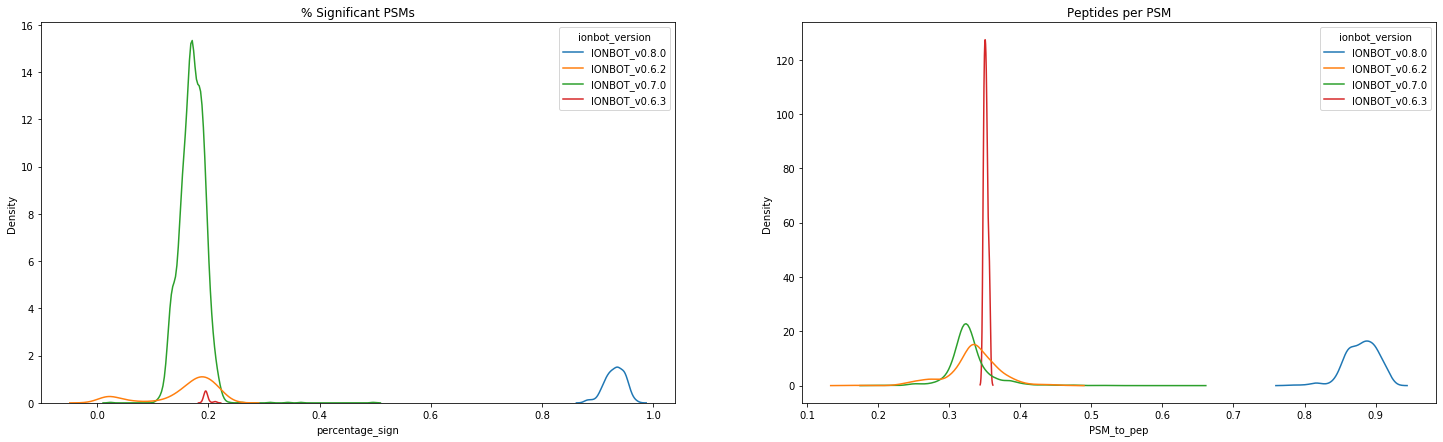

In [10]:
fig, ax = plt.subplots(1,2, figsize = (25,7))

ax[0].set_title("% Significant PSMs")
ax[1].set_title("Peptides per PSM")


sns.kdeplot(meta["percentage_sign"], ax = ax[0], hue = meta["ionbot_version"])
sns.kdeplot(meta["PSM_to_pep"], ax = ax[1], hue = meta["ionbot_version"], common_norm=False)

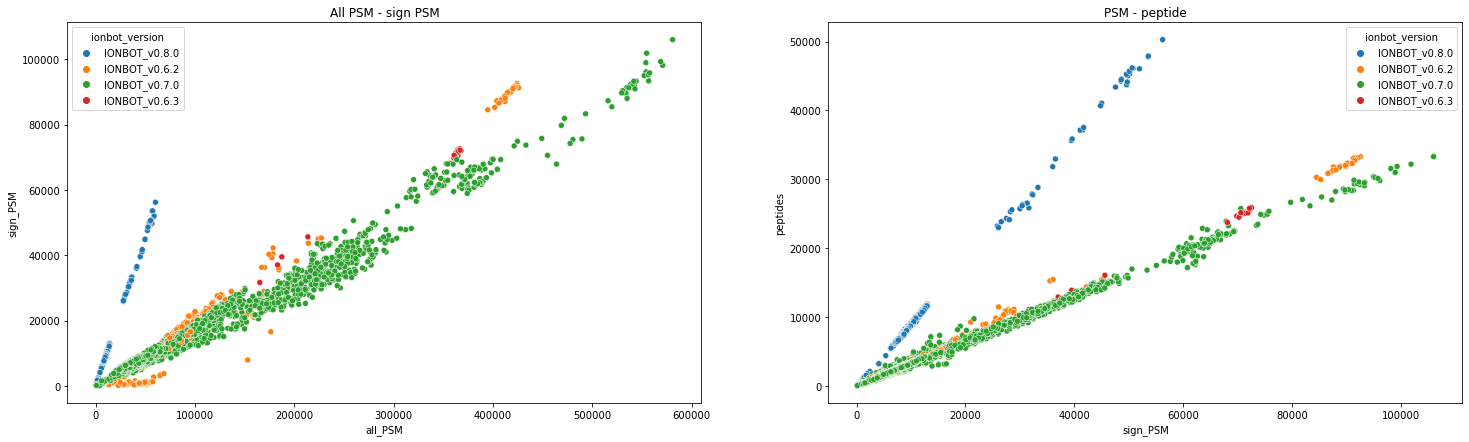

In [5]:
fig, ax = plt.subplots(1,2, figsize = (25,7))

ax[0].set_title("All PSM - sign PSM")
ax[1].set_title("PSM - peptide")

sns.scatterplot(x= meta["all_PSM"], y = meta["sign_PSM"], ax = ax[0], hue = meta["ionbot_version"], legend=True)
sns.scatterplot(x= meta["sign_PSM"], y = meta["peptides"], ax = ax[1], hue = meta["ionbot_version"], legend=True)

In [6]:
meta[meta.assay_id.isin([31376, 31401])]

,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,...,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,Type,percentage_sign,PSM_to_pep
1628,31376,1829,160116_K052_OffLRP_RP_f02,569,KO52,myeloid leukemia,/,blood,/,NaN,...,448,172,131,in-solution,Orbitrap Fusion ETD,30295032,1,Fraction,0.019153,0.383929
1638,31401,1829,20160205_PGM_K052_SCX_RP_03,569,KO52,myeloid leukemia,/,blood,/,NaN,...,640,236,178,in-solution,Orbitrap Fusion ETD,30295032,2,Fraction,0.021688,0.368750


In [4]:
nsaf[nsaf.index.isin(meta[meta.instrument == "Orbitrap Fusion ETD"].assay_id)].notna().sum(axis=1)

assay_id
31376    1038
31401    2136
dtype: int64

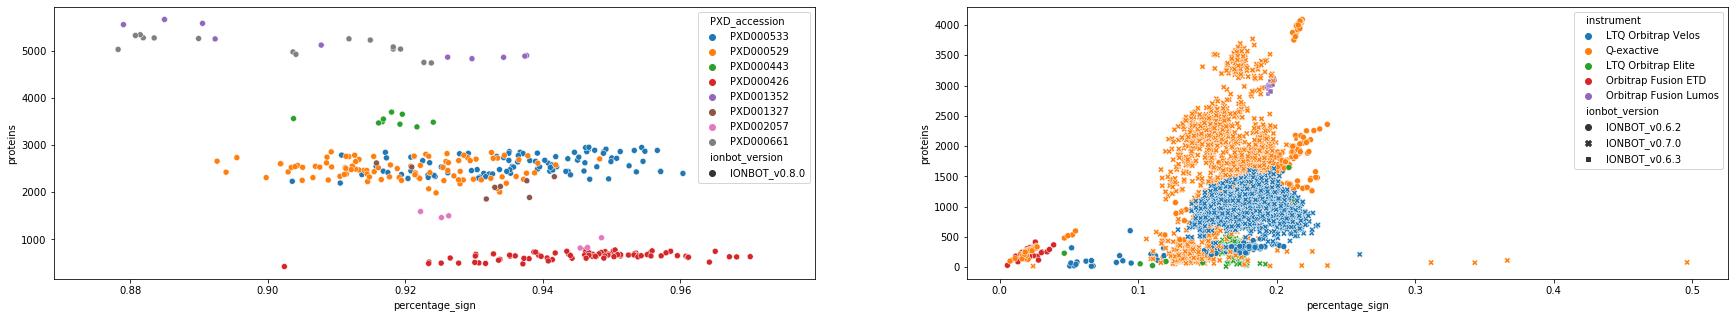

<Figure size 504x504 with 0 Axes>

In [15]:
fig, ax = plt.subplots(1,2, figsize=(30,5))
plt.figure(figsize=(7,7))
sns.scatterplot(data=meta[meta.percentage_sign > .75], x="percentage_sign", y="proteins", hue="PXD_accession", style="ionbot_version", ax = ax[0])
sns.scatterplot(data=meta[meta.percentage_sign < .75], x="percentage_sign", y="proteins", hue="instrument", style="ionbot_version", ax = ax[1])

In [53]:
# sum the PSMs and peptides of fractions?

pooled_meta = {"experiment_type" : {}, 
               "PXD_accession": {},
               "fraction": {}, 
               "all_PSM": {}, 
               "sign_PSM": {},  
               "proteins": {},
               "ionbot_version": {}}

pxds = meta.PXD_accession.unique()

for pxd in pxds:
    pxd_meta = meta[meta.PXD_accession == pxd]

    whole_lysate = []
    fractions = {}

    for i, row in pxd_meta.iterrows():
        if row["pool_id"] == 0:
            whole_lysate.append(row["assay_id"])
        elif row["pool_id"] not in fractions.keys():
            fractions[row["pool_id"]] = [row["assay_id"]]
        else:
            fractions[row["pool_id"]].append(row["assay_id"])

    for pool_id, assay_ids in fractions.items():
        pooled_meta['proteins'][assay_ids[0]] = (nsaf.loc[assay_ids,:].notna().sum(axis=0) != 0).sum() # Unique proteins identified
        pooled_meta["all_PSM"][assay_ids[0]] = meta[meta.assay_id.isin(assay_ids)].all_PSM.sum()
        pooled_meta['sign_PSM'][assay_ids[0]] = meta[meta.assay_id.isin(assay_ids)].sign_PSM.sum()
        pooled_meta['fraction'][assay_ids[0]] = 'Yes'
        pooled_meta['experiment_type'][assay_ids[0]] = meta[meta.assay_id == assay_ids[0]].experiment_type.values[0]
        pooled_meta['PXD_accession'][assay_ids[0]] = meta[meta.assay_id == assay_ids[0]].PXD_accession.values[0]
        pooled_meta["ionbot_version"][assay_ids[0]] = meta[meta.assay_id == assay_ids[0]].ionbot_version.values[0]

    for lysate in whole_lysate:
        pooled_meta['proteins'][lysate] = nsaf.loc[lysate,:].notna().sum() # Unique proteins identified
        pooled_meta["all_PSM"][lysate] = meta[meta.assay_id == lysate].all_PSM.values[0]
        pooled_meta['sign_PSM'][lysate] = meta[meta.assay_id == lysate].sign_PSM.values[0]
        pooled_meta['fraction'][lysate] = 'No'
        pooled_meta['experiment_type'][lysate] = meta[meta.assay_id == lysate].experiment_type.values[0]
        pooled_meta['PXD_accession'][lysate] = meta[meta.assay_id == lysate].PXD_accession.values[0]
        pooled_meta["ionbot_version"][lysate] = meta[meta.assay_id == lysate].ionbot_version.values[0]
    


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [54]:
pooled_meta = pd.DataFrame(pooled_meta)

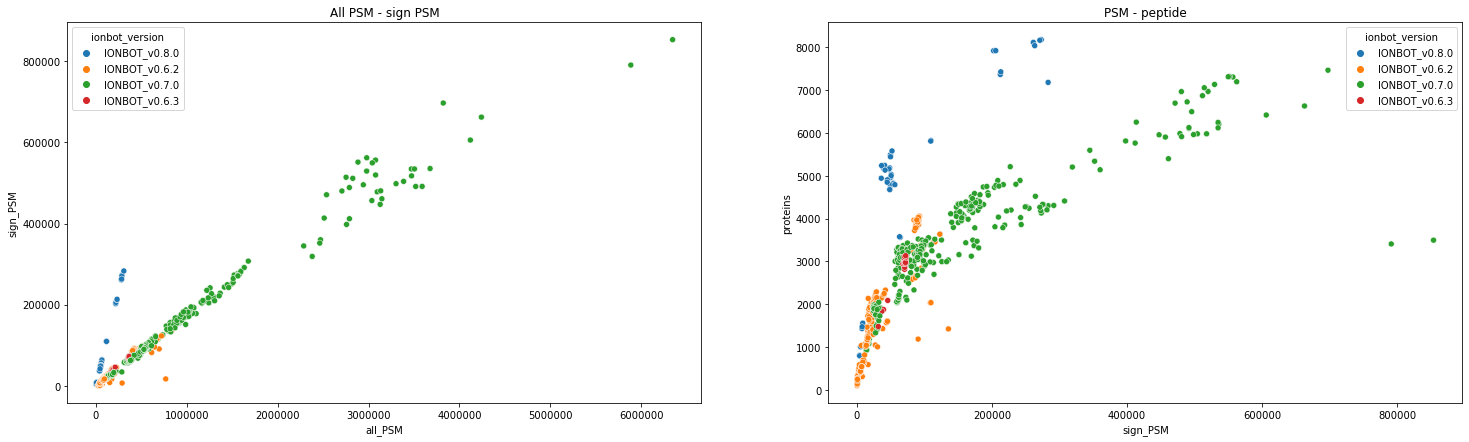

In [56]:
fig, ax = plt.subplots(1,2, figsize = (25,7))

ax[0].set_title("All PSM - sign PSM")
ax[1].set_title("PSM - peptide")

sns.scatterplot(x= pooled_meta["all_PSM"], y = pooled_meta["sign_PSM"], ax = ax[0], hue = pooled_meta["ionbot_version"], legend=True)
sns.scatterplot(x= pooled_meta["sign_PSM"], y = pooled_meta["proteins"], ax = ax[1], hue = pooled_meta["ionbot_version"], legend=True)

In [57]:
pooled_meta["percentage_sign"] = pooled_meta.apply(lambda x: x["sign_PSM"]/ x["all_PSM"], axis=1)
pooled_meta["PSM_to_prot"] = pooled_meta.apply(lambda x: x["proteins"] / x["sign_PSM"], axis = 1)

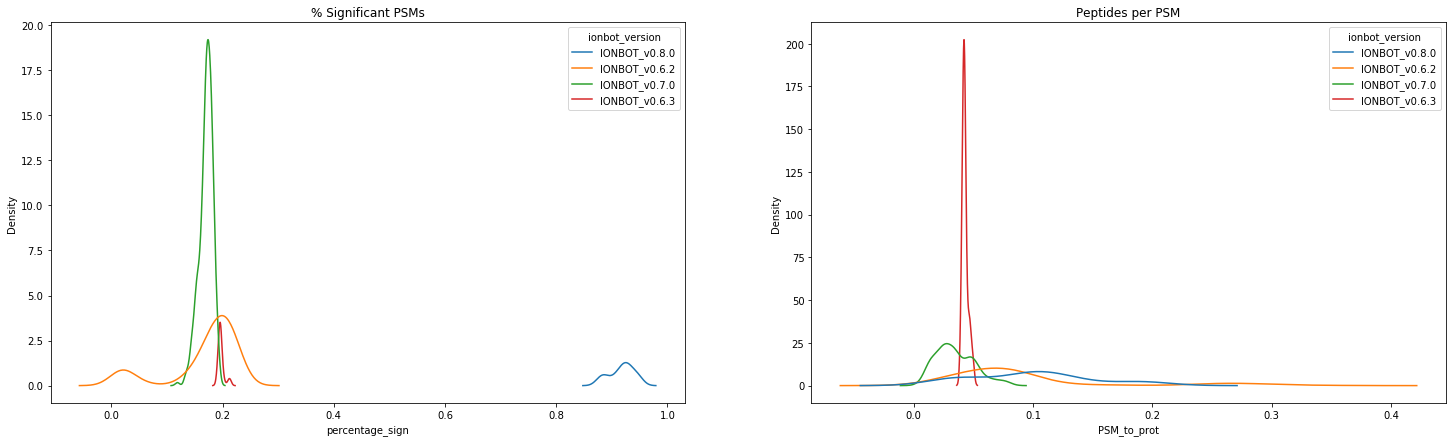

In [59]:
fig, ax = plt.subplots(1,2, figsize = (25,7))

ax[0].set_title("% Significant PSMs")
ax[1].set_title("Peptides per PSM")


sns.kdeplot(pooled_meta["percentage_sign"], ax = ax[0], hue = pooled_meta["ionbot_version"])
sns.kdeplot(pooled_meta["PSM_to_prot"], ax = ax[1], hue = pooled_meta["ionbot_version"], common_norm=False)

In [62]:
pooled_meta

,experiment_type,PXD_accession,fraction,all_PSM,sign_PSM,proteins,ionbot_version,percentage_sign,PSM_to_prot
30960,in-solution,PXD000533,Yes,287885,272852,8180,IONBOT_v0.8.0,0.947781,0.029980
30961,in-solution,PXD000533,Yes,286406,270794,8166,IONBOT_v0.8.0,0.945490,0.030156
31008,in-solution,PXD000533,Yes,281675,261191,8117,IONBOT_v0.8.0,0.927278,0.031077
31009,in-solution,PXD000533,Yes,283620,263218,8040,IONBOT_v0.8.0,0.928066,0.030545
31488,in-solution,PXD000529,Yes,218441,202334,7921,IONBOT_v0.8.0,0.926264,0.039148
...,...,...,...,...,...,...,...,...,...
36299,in-solution,PXD005354,Yes,892606,161342,4389,IONBOT_v0.7.0,0.180754,0.027203
36344,in-solution,PXD005354,Yes,1013598,181570,4395,IONBOT_v0.7.0,0.179134,0.024206
36347,in-solution,PXD005354,Yes,926487,169757,4295,IONBOT_v0.7.0,0.183227,0.025301
36350,in-solution,PXD005354,Yes,940252,175939,4371,IONBOT_v0.7.0,0.187119,0.024844


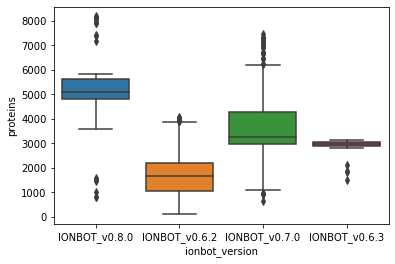

In [66]:
sns.boxplot(data=pooled_meta, y="proteins", x="ionbot_version")